### Content

+ **[Evaluate the Best Model](#bestmodel)**
+ **[Empirical Cumulative Distribution Function](#ecdf)**
+ **[Exploring on Regressors](#exp)**
+ **[Evaluate the TFIDF Random Forest Model](#tfidf)**
+ **[Investigate the Model Structure](#tree)**
+ **[Model Against the Simulated Data](#simulated)**
+ **[Evaluate the Linear Regression with Simulated Data](#lm)**
+ **[Gaussian Transformation in Target Variable](#gaussian)**
+ **[Actionable Insights](#actionable)**

### Import Modules and Obtain Datasets

In [1]:
# Plot
from matplotlib import pyplot as plt, gridspec as grid, cm
from sklearn import tree
import seaborn as sns

# Statistics tools
from scipy import stats
import random

# Read Data
import urllib
import requests
import io
from zipfile import ZipFile

# Data Manipulation
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
Xtrainurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/X_train.zip'
Xvalidurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/X_valid.zip'
Xtestiurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/X_test.zip'

ytrainurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/y_train?raw=true'
yvalidurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/y_valid?raw=true'
ytestiurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/y_test?raw=true'

In [3]:
# Read X_train dataset
url = urllib.request.urlopen(Xtrainurl)
unzipfile = ZipFile(io.BytesIO(url.read()))
file = unzipfile.open("X_train")
X_train = pd.read_csv(file, encoding='cp1252').drop('Unnamed: 0', 
                                                    axis=1)
file.close()

# Read X_valid dataset
url = urllib.request.urlopen(Xvalidurl)
unzipfile = ZipFile(io.BytesIO(url.read()))
file = unzipfile.open("X_valid")
X_valid = pd.read_csv(file, encoding='cp1252').drop('Unnamed: 0', 
                                                    axis=1)
file.close()

# Read X_test dataset
url = urllib.request.urlopen(Xtestiurl)
unzipfile = ZipFile(io.BytesIO(url.read()))
file = unzipfile.open("X_test")
X_test = pd.read_csv(file, encoding='cp1252').drop('Unnamed: 0', 
                                                    axis=1)
file.close()

In [4]:
# Read y_train dataset
response = requests.get(ytrainurl)
response.raise_for_status()
y_train = np.load(io.BytesIO(response.content))

# Read y_valid dataset
response = requests.get(yvalidurl)
response.raise_for_status()
y_valid = np.load(io.BytesIO(response.content))

# Read y_test dataset
response = requests.get(ytestiurl)
response.raise_for_status()
y_test = np.load(io.BytesIO(response.content))

### Evaluate the Best Model <a id='bestmodel'></a>

In [5]:
def r2_calculator(predict, true):
    merged = pd.concat([pd.DataFrame(list(predict)).rename(columns={0:'predicted'}), 
           pd.DataFrame(list(true)).rename(columns={0:'true'})],axis=1)
    
    # 1 - (predict - true)^2/(true - mean(true))^2 = 1 - RSS/TSS = r_2
    r2 = 1 - sum((merged['predicted'] - merged['true'])**2)/sum((merged['true'] - np.mean(merged['true']))**2)
    
    return r2

def adjusted_r2_calculator(predict, true):
    r2 = r2_calculator(predict, true) # r_2
    n = len(true)                     # number of rows
    k = len(X_train.columns)         # number of parameters
    
    adj_r2 = 1 - ((1-r2)*(n-1))/(n-k-1)    # 1 - [(1 - r_2)*(n - 1)/(n - k - 1)] = adjusted r^2
    
    return adj_r2

def mae_and_mse_calculator(predict, true):
    merged = pd.concat([pd.DataFrame(list(predict)).rename(columns={0:'predicted'}), 
           pd.DataFrame(list(true)).rename(columns={0:'true'})],axis=1)
    mae = sum(np.abs(merged['true'] - merged['predicted']))/len(true) # 1/n ∑ |true - predict|   = MAE
    mse = sum((merged['true'] - merged['predicted'])**2)/len(true)    # 1/n ∑ (true - predict)^2 = MSE
    
    return mae, mse

In [6]:
X_train = X_train.iloc[:,0:18]
X_valid = X_valid.iloc[:,0:18]
X_test = X_test.iloc[:,0:18]

In [7]:
# Random Forest Regression
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train.ravel())

RandomForestRegressor()

In [8]:
print('Validation Set with PCA')
print('R2: ' + str(round(r2_calculator(rfr_model.predict(X_valid),y_valid),4)))
print('Adjusted R2: ' + str(round(adjusted_r2_calculator(rfr_model.predict(X_valid),y_valid),4)))
print('MAE: ' + str(round(mae_and_mse_calculator(rfr_model.predict(X_valid),y_valid)[0],4)))
print('RMSE: ' + str(round(mae_and_mse_calculator(rfr_model.predict(X_valid),y_valid)[1]**0.5,4)))

Validation Set with PCA
R2: 0.9091
Adjusted R2: 0.9091
MAE: 0.0687
RMSE: 0.1107


### Empirical Cumulative Distribution Function <a id='ecdf'></a>

In [9]:
# Write the ECDF function and Rescaling function using Z Score
def rescale(data):
    u = np.mean(data)
    s = np.std(data)
    z = (data - u)/s
    return z

def ecdf(data):
    n = len(data)
    x = np.sort(rescale(data))
    y = np.arange(1,n+1)/n
    return x,y

In [10]:
# True vs Predicted Target Variable
xtrue, ytrue = ecdf(list(pd.DataFrame(y_train)[0]))
xpred, ypred = ecdf(rfr_model.predict(X_train))

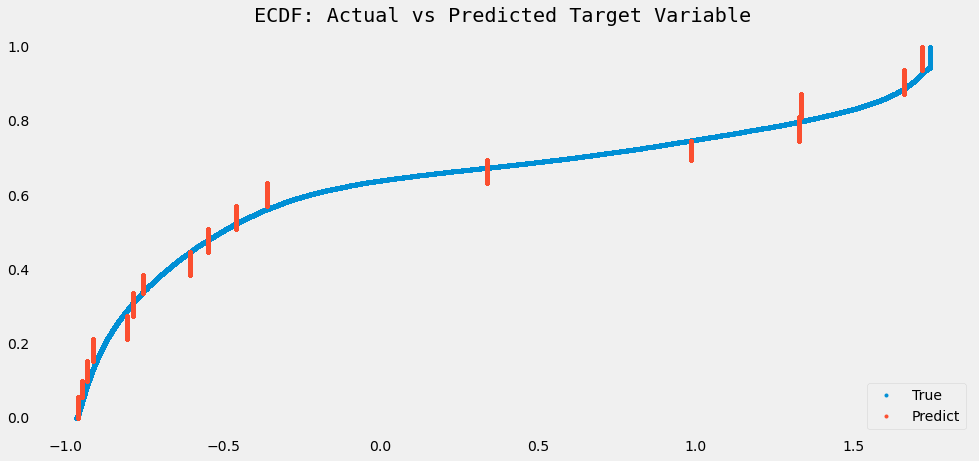

In [11]:
# Plot ECDF
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,7))
plt.plot(xtrue,ytrue,marker='.',linestyle='none',label='True')
plt.plot(xpred,ypred,marker='.',linestyle='none',label='Predict')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.title('ECDF: Actual vs Predicted Target Variable',family = 'monospace')
plt.show()

### Exploring on Regressors <a id='exp'></a>

In [12]:
# Sum all columns for each row and ECDFize this sum column
xsum, ysum = ecdf(X_train.sum(axis=1))

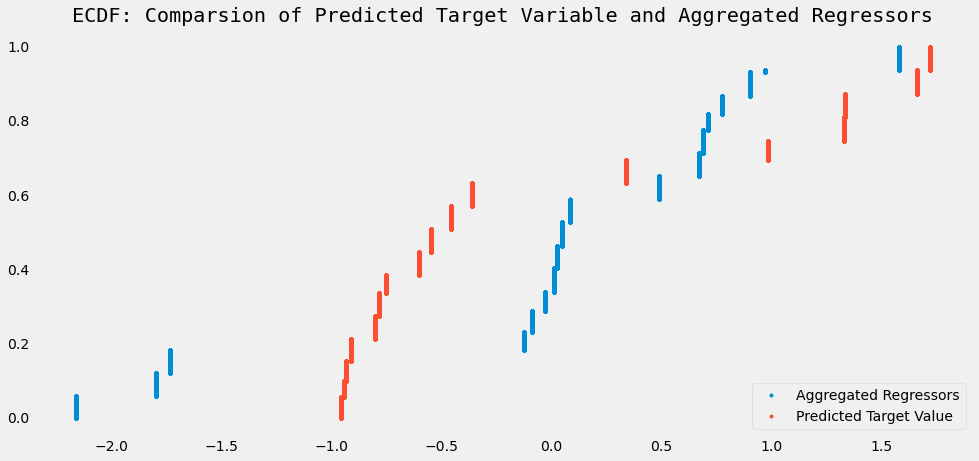

In [13]:
# Plot ECDF
plt.figure(figsize = (15,7))
plt.plot(xsum,ysum,marker='.',linestyle='none',label='Aggregated Regressors')
plt.plot(xpred,ypred,marker='.',linestyle='none',label='Predicted Target Value')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.title('ECDF: Comparsion of Predicted Target Variable and Aggregated Regressors',family = 'monospace')
plt.show()

In [14]:
# ECDFize top four independent variables
xpc0, ypc0 = ecdf(X_train['pc_0'])
xpc1, ypc1 = ecdf(X_train['pc_1'])
xpc2, ypc2 = ecdf(X_train['pc_2'])
xpc3, yp3 = ecdf(X_train['pc_3'])

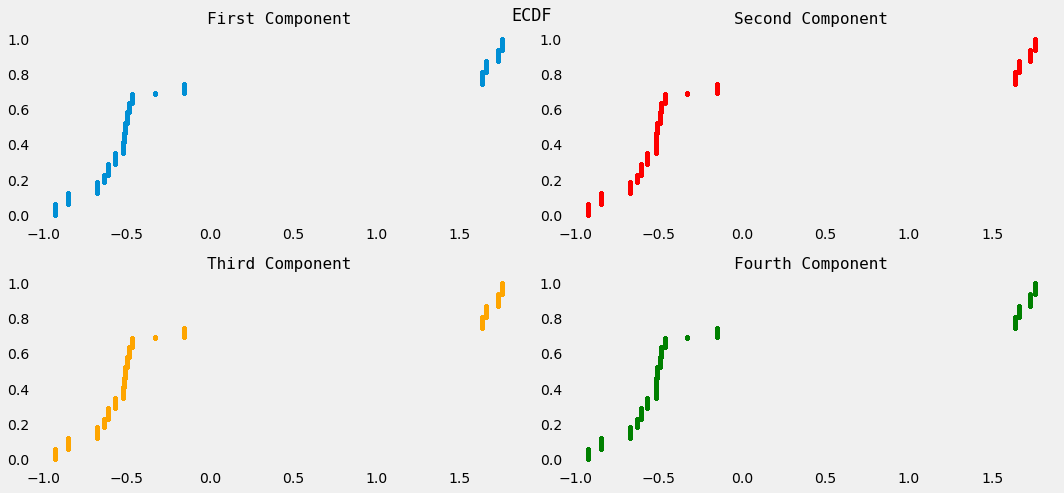

In [15]:
fig, ax = plt.subplots(2,2,figsize=(15,7))
ax[0,0].plot(xpc0,ypc0,marker='.',linestyle='none')
ax[0,0].set_title('First Component',fontsize=16,family='monospace')
ax[0,0].grid(False)

ax[0,1].plot(xpc0,ypc0,marker='.',linestyle='none',color='red')
ax[0,1].set_title('Second Component',fontsize=16,family='monospace')
ax[0,1].grid(False)

ax[1,0].plot(xpc0,ypc0,marker='.',linestyle='none',color='orange')
ax[1,0].set_title('Third Component',fontsize=16,family='monospace')
ax[1,0].grid(False)

ax[1,1].plot(xpc0,ypc0,marker='.',linestyle='none',color='green')
ax[1,1].set_title('Fourth Component',fontsize=16,family='monospace')
ax[1,1].grid(False)

fig.tight_layout()
plt.grid(False)
plt.suptitle('ECDF',family = 'monospace')
plt.show()

### Evaluate the TFIDF Random Forest Model <a id='tfidf'></a>

In [16]:
# Read the TFIDF X_train file from GitHub
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/X_TFIDF_train.zip?raw=true')
unzipfile = ZipFile(io.BytesIO(url.read()))
file = unzipfile.open("X_TFIDF_train")
X_TFIDF_train = pd.read_csv(file, encoding='cp1252').drop('Unnamed: 0', 
                                                    axis=1)
file.close()

In [17]:
# Random Forest Regression
TFIDF_rfr_model = RandomForestRegressor()
TFIDF_rfr_model.fit(X_TFIDF_train, y_train.ravel())

RandomForestRegressor()

In [18]:
# True vs Predicted Target Variable
xpred1, ypred1 = ecdf(TFIDF_rfr_model.predict(X_TFIDF_train))

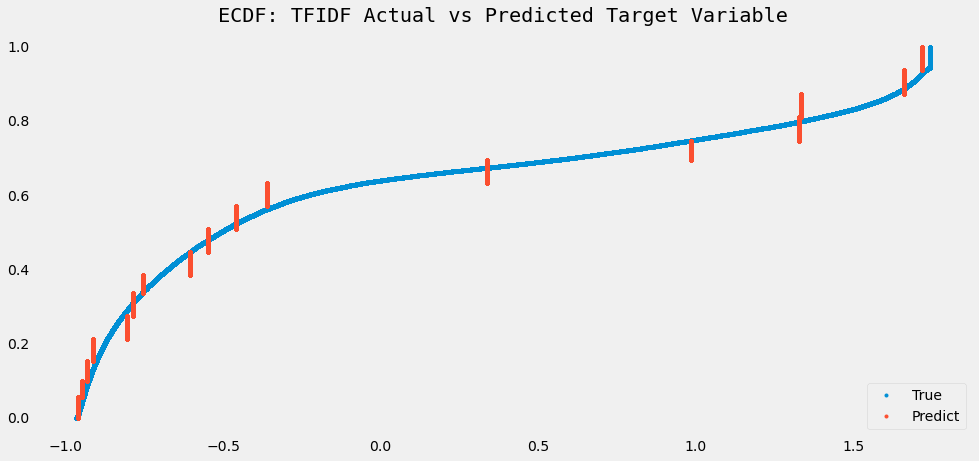

In [19]:
# Plot ECDF
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,7))
plt.plot(xtrue,ytrue,marker='.',linestyle='none',label='True')
plt.plot(xpred,ypred,marker='.',linestyle='none',label='Predict')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.title('ECDF: TFIDF Actual vs Predicted Target Variable',family = 'monospace')
plt.show()

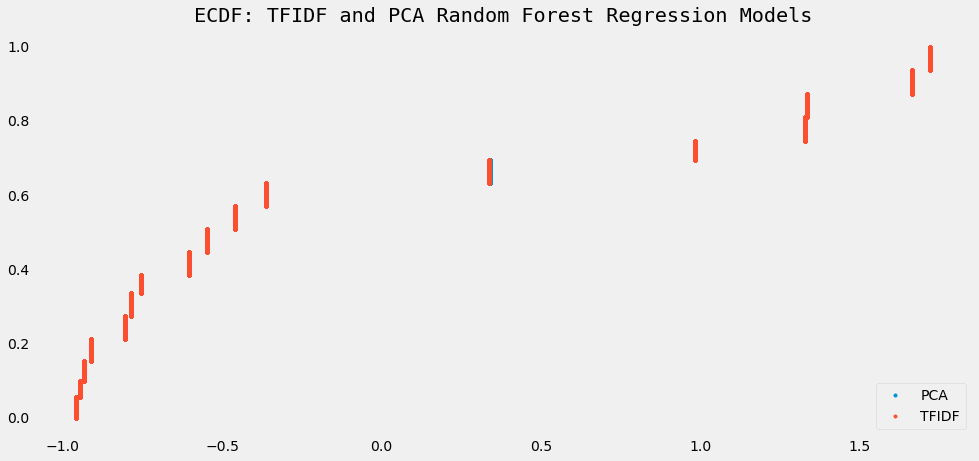

In [20]:
# Plot ECDF
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,7))
plt.plot(xpred,ypred,marker='.',linestyle='none',label='PCA')
plt.plot(xpred1,ypred1,marker='.',linestyle='none',label='TFIDF')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.title('ECDF: TFIDF and PCA Random Forest Regression Models',family = 'monospace')
plt.show()

In [21]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    result = stats.f.cdf(f, dfn, dfd)  #find p-value of F test statistic 
    if result > 0.5:
        p = 1 - result
    else:
        p = result
    return f, p

#perform F-test
print('Given that the data is from training set, the p-value of F Distribution is '+str(round(f_test(xpred,xpred1)[1],2))+
      ' that fails to reject the null hypothesis of two models that both variances are not different from each other.')

Given that the data is from training set, the p-value of F Distribution is 0.5 that fails to reject the null hypothesis of two models that both variances are not different from each other.


In [22]:
# Sum all columns for each row and ECDFize this sum column
xsum1, ysum1 = ecdf(X_TFIDF_train.sum(axis=1))

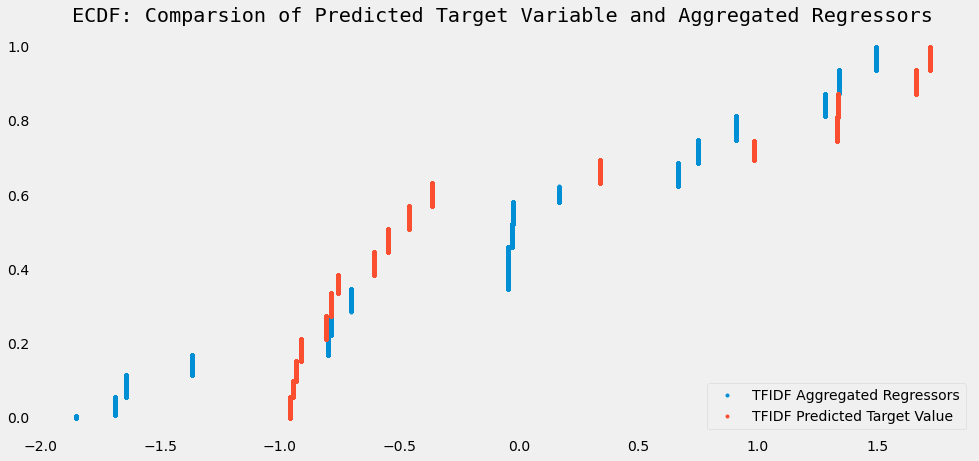

In [23]:
# Plot ECDF
plt.figure(figsize = (15,7))
plt.plot(xsum1,ysum1,marker='.',linestyle='none',label='TFIDF Aggregated Regressors')
plt.plot(xpred1,ypred1,marker='.',linestyle='none',label='TFIDF Predicted Target Value')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.title('ECDF: Comparsion of Predicted Target Variable and Aggregated Regressors',family = 'monospace')
plt.show()

### Investigate the Model Structure <a id='tree'></a>

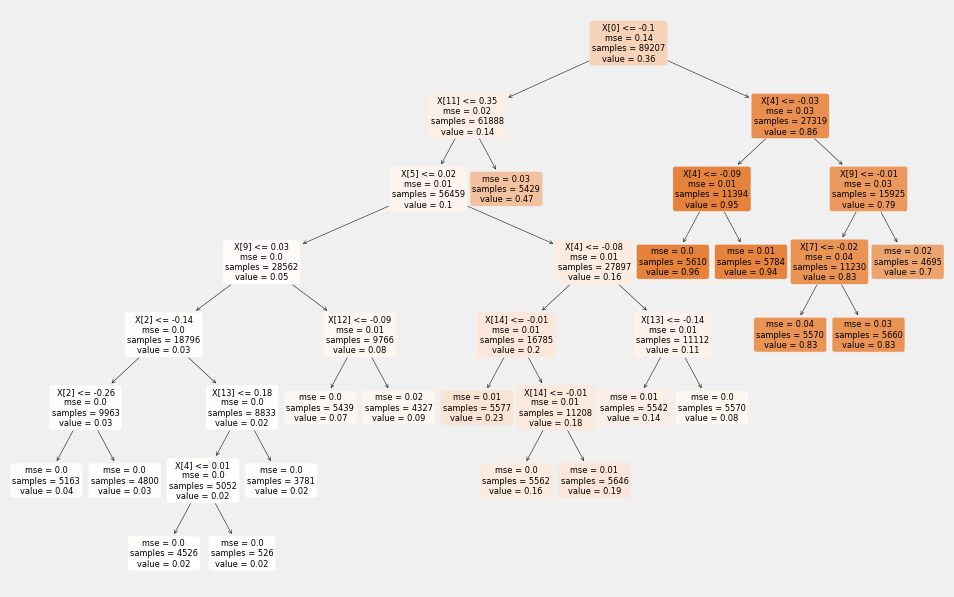

<Figure size 2880x1440 with 0 Axes>

In [24]:
# Extract single tree of random forest model with PCA
estimator = rfr_model.estimators_[90]

# Plot the phylogenetic structure
fig, ax = plt.subplots(figsize=(15,10))
plt.figure(figsize = (40,20))
tree.plot_tree(estimator,
           filled = True, proportion = False,
           precision = 2, rounded=True, ax = ax)
plt.show()

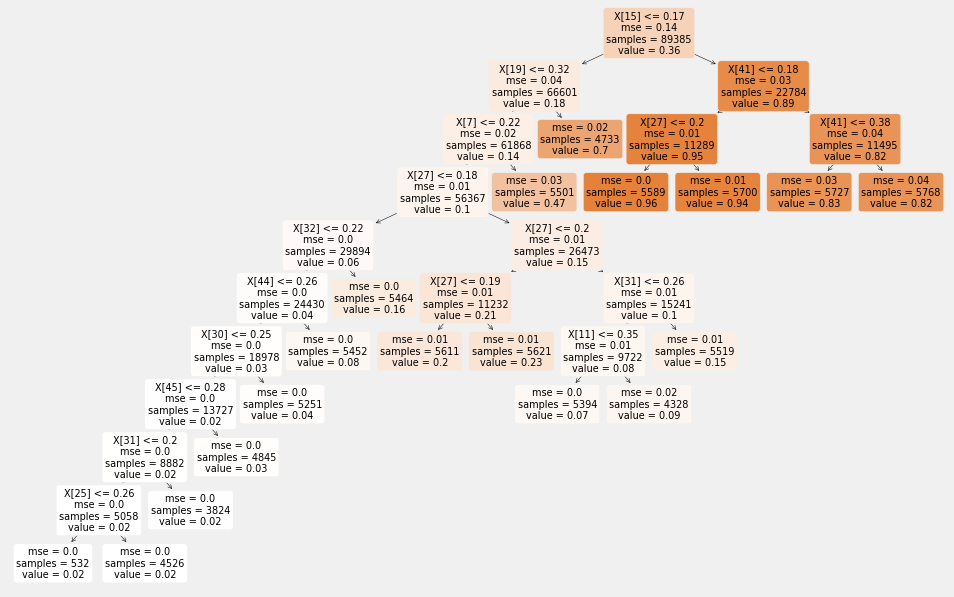

<Figure size 2880x1440 with 0 Axes>

In [25]:
# Extract single tree of TFIDF random forest model
estimator = TFIDF_rfr_model.estimators_[90]

# Plot the phylogenetic structure
fig, ax = plt.subplots(figsize=(15,10))
plt.figure(figsize = (40,20))
tree.plot_tree(estimator,
           filled = True, proportion = False,
           precision = 2, rounded=True, ax = ax)
plt.show()

### Model Against the Simulated Data <a id = 'simulated'></a>

In [26]:
# Create the simulated data for pca
simulated_list = []
for i in range(1800000):
    simulated_list.append(random.random())

j = 1
simulated_dictionary = {}
for i in range(len(X_train.columns)):
    k = j+1000000-1
    simulated_dictionary[i] = simulated_list[j:k]

simulated_data = pd.DataFrame(simulated_dictionary)

In [27]:
pca_pred = rfr_model.predict(simulated_data)

In [28]:
# Create the simulated data for TFIDF
simulated_list = []
for i in range(4900000):
    simulated_list.append(random.random())

j = 1
simulated_dictionary = {}
for i in range(len(X_TFIDF_train.columns)):
    k = j+1000000-1
    simulated_dictionary[i] = simulated_list[j:k]
    

simulated_data = pd.DataFrame(simulated_dictionary)

In [29]:
tfidf_pred = TFIDF_rfr_model.predict(simulated_data)

In [30]:
#perform F-test
print('Given that the data is simulated, the p-value of F Distribution is '+str(round(f_test(pca_pred,tfidf_pred)[1],2))+
      ' that reject the null hypothesis of two models that both variances are not different from each other.')

Given that the data is simulated, the p-value of F Distribution is 0.0 that reject the null hypothesis of two models that both variances are not different from each other.


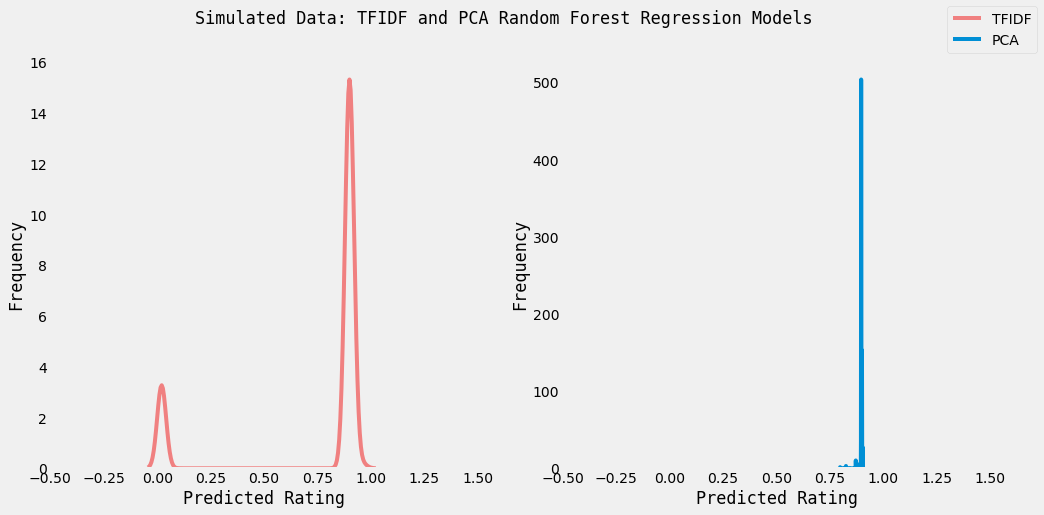

In [31]:
# Plot Density Plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.kdeplot(tfidf_pred,label='TFIDF',color='lightcoral', ax = ax[0])
sns.kdeplot(pca_pred,label='PCA', ax = ax[1])
for i in range(2):
    ax[i].set_xlabel('Predicted Rating',family='monospace')
    ax[i].set_ylabel('Frequency',family='monospace')
    ax[i].set_xlim(-0.5,1.5)
    ax[i].grid(False)
fig.legend()
plt.grid(False)
fig.suptitle('Simulated Data: TFIDF and PCA Random Forest Regression Models',family = 'monospace')
plt.show()

### Evaluate the Linear Regression with Simulated Data <a id = 'lm'></a>

In [32]:
# Create and fit X TFIDF and y trainings
tfidf_lm = LinearRegression()
tfidf_lm.fit(X_TFIDF_train, y_train)

# Predict the model using TFIDF simulated data
tfidf_pred= np.array(pd.DataFrame(tfidf_lm.predict(simulated_data))[0])

In [33]:
# Create and fit X PCA and y trainings
pca_lm = LinearRegression()
pca_lm.fit(X_train, y_train)

# Create the simulated data for pca
simulated_list = []
for i in range(1800000):
    simulated_list.append(random.random())

j = 1
simulated_dictionary = {}
for i in range(len(X_train.columns)):
    k = j+1000000-1
    simulated_dictionary[i] = simulated_list[j:k]

simulated_data = pd.DataFrame(simulated_dictionary)

# Predict the model using PCA simulated data
pca_pred= np.array(pd.DataFrame(pca_lm.predict(simulated_data))[0])

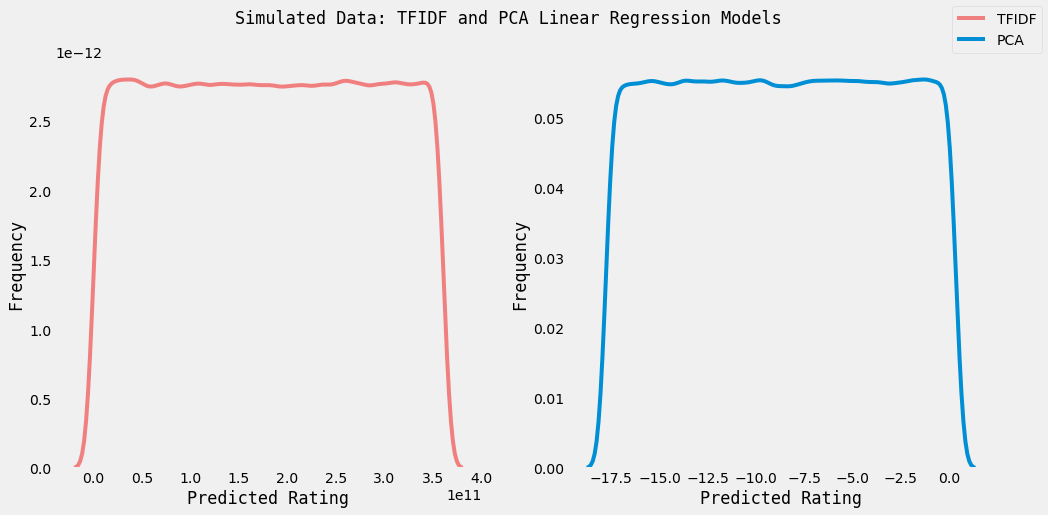

In [34]:
# Plot Density Plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.kdeplot(tfidf_pred,label='TFIDF',color='lightcoral', ax = ax[0])
sns.kdeplot(pca_pred,label='PCA', ax = ax[1])
for i in range(2):
    ax[i].set_xlabel('Predicted Rating',family='monospace')
    ax[i].set_ylabel('Frequency',family='monospace')
    ax[i].grid(False)
fig.legend()
plt.grid(False)
fig.suptitle('Simulated Data: TFIDF and PCA Linear Regression Models',family = 'monospace')
plt.show()

In [35]:
pca_parameters = {}
for i in range(len(list(pd.DataFrame(pca_lm.coef_)))):
    pca_parameters[list(X_train.columns)[i]] = list(pd.DataFrame(pca_lm.coef_).iloc[:,i])

tfidf_parameters = {}
for i in range(len(list(pd.DataFrame(tfidf_lm.coef_)))):
    tfidf_parameters[list(X_TFIDF_train.columns)[i]] = list(pd.DataFrame(tfidf_lm.coef_).iloc[:,i])

In [36]:
colors = cm.get_cmap('Blues')

display(pd.DataFrame(pca_parameters).melt().rename(
    columns={'variable':'parameters','value':'coefficients'}).style.background_gradient(
    cmap=colors).set_precision(4))

,parameters,coefficients
0,pc_0,0.7746
1,pc_1,0.0366
2,pc_2,0.1458
3,pc_3,-0.0082
4,pc_4,0.0745
5,pc_5,-0.0313
6,pc_6,0.3433
7,pc_7,-0.1487
8,pc_8,-0.0023
9,pc_9,-0.0821


In [37]:
display(pd.DataFrame(tfidf_parameters).melt().rename(
    columns={'variable':'parameters','value':'coefficients'}).style.background_gradient(
    cmap=colors).set_precision(4))

,parameters,coefficients
0,ability,-11311504525.9506
1,activities,24782619755.6499
2,antianxiety,-4604372060.4824
3,antipsychotic,-16329686025.2009
4,appropriately,-365830977038.7865
5,assessed,323570219138.9838
6,bladder,89963452338.7163
7,bowels,-171240068467.3178
8,catheter,-7738404178.4362
9,control,903384016548.3258


In [38]:
print('Training Set with PCA')
print('R2: ' + str(round(r2_calculator(pca_lm.predict(X_train),y_train),4)))
print('Adjusted R2: ' + str(round(adjusted_r2_calculator(pca_lm.predict(X_train),y_train),4)))
print('MAE: ' + str(round(mae_and_mse_calculator(pca_lm.predict(X_train),y_train)[0],4)))
print('RMSE: ' + str(round(mae_and_mse_calculator(pca_lm.predict(X_train),y_train)[1]**0.5,4)))
print('')
print('TFIDF Training Set')
print('R2: ' + str(round(r2_calculator(tfidf_lm.predict(X_TFIDF_train),y_train),4)))
print('Adjusted R2: ' + str(round(adjusted_r2_calculator(tfidf_lm.predict(X_TFIDF_train),y_train),4)))
print('MAE: ' + str(round(mae_and_mse_calculator(tfidf_lm.predict(X_TFIDF_train),y_train)[0],4)))
print('RMSE: ' + str(round(mae_and_mse_calculator(tfidf_lm.predict(X_TFIDF_train),y_train)[1]**0.5,4)))

Training Set with PCA
R2: 0.9095
Adjusted R2: 0.9095
MAE: 0.0689
RMSE: 0.1109

TFIDF Training Set
R2: 0.9095
Adjusted R2: 0.9095
MAE: 0.0689
RMSE: 0.1109


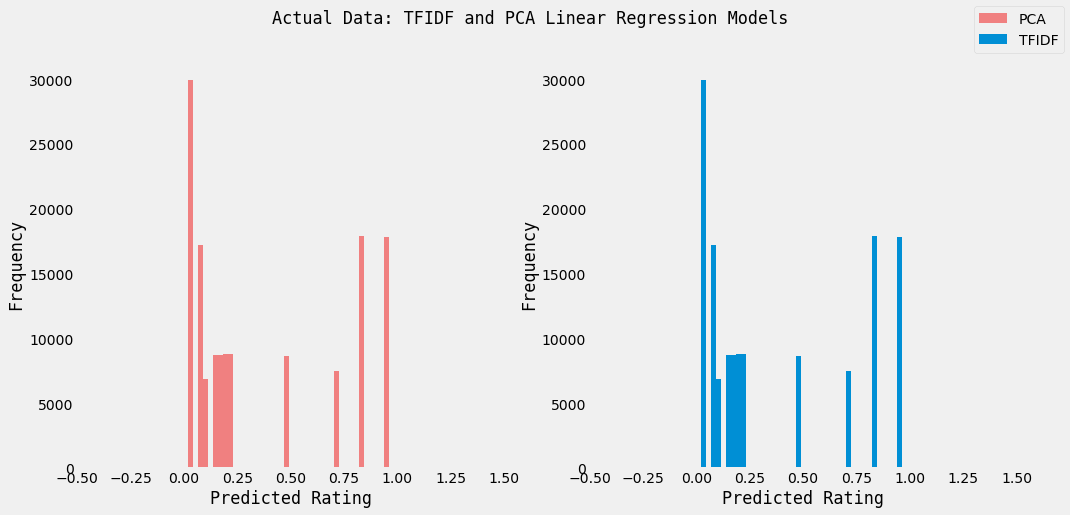

In [39]:
# Using training to predict the models
tfidf_pred = tfidf_lm.predict(X_TFIDF_train)
pca_pred = pca_lm.predict(X_train)

# Plot Histograms
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].hist(tfidf_pred,label='PCA',bins = 40,color='lightcoral')
ax[1].hist(pca_pred,label='TFIDF',bins=40)
for i in range(2):
    ax[i].set_xlabel('Predicted Rating',family='monospace')
    ax[i].set_ylabel('Frequency',family='monospace')
    ax[i].grid(False)
    ax[i].set_xlim(-0.5,1.5)
fig.legend()
fig.suptitle('Actual Data: TFIDF and PCA Linear Regression Models',family = 'monospace')
plt.show()

In [40]:
print('Given that the data is from training set, the p-value of F Distribution is '+str(round(f_test(pca_pred,tfidf_pred)[1],2))+
      ' that rejects the null hypothesis of two models that both variances are not different from each other.')

Given that the data is from training set, the p-value of F Distribution is 0.45 that rejects the null hypothesis of two models that both variances are not different from each other.


### Gaussian Transformation in Target Variable <a id = 'gaussian'></a>

In [41]:
# Convert list into Pandas Data Frame and eliminate zeroes
y_training = pd.DataFrame(y_train).rename(columns={0:'original'})
y_training = y_training[y_training['original'] > 0]

In [42]:
def min_max_scaling(data):
    mini = np.min(data)
    maxi = np.max(data)
    rescaling = (data - mini)/(maxi - mini)
    return rescaling

In [43]:
y_training['log'] = np.log(y_training['original'])/np.log(0.99999)
y_training['boxcox'], lmbda = stats.boxcox(y_training['original'])
y_training['yeojohnson'], lmbda = stats.yeojohnson(y_training['original'])

In [44]:
y_training['log'] = min_max_scaling(y_training['log'])
y_training['boxcox'] = min_max_scaling(y_training['boxcox'])
y_training['yeojohnson'] = min_max_scaling(y_training['yeojohnson'])

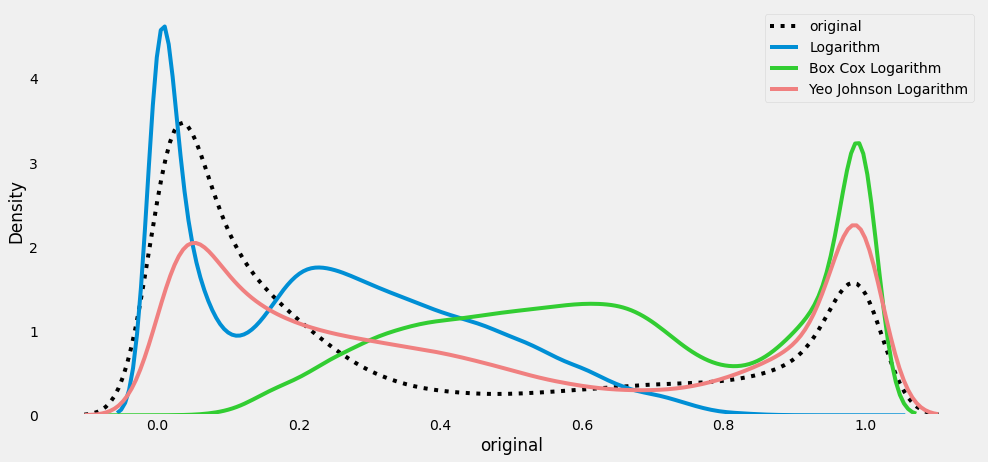

In [45]:
plt.figure(figsize =(15,7))
sns.kdeplot(y_training['original'],label='original',color='black',linestyle=':')
sns.kdeplot(y_training['log'], label = 'Logarithm')
sns.kdeplot(y_training['boxcox'], label = 'Box Cox Logarithm',color='limegreen')
sns.kdeplot(y_training['yeojohnson'], label = 'Yeo Johnson Logarithm',color='lightcoral')
plt.grid(False)
plt.legend(loc='upper right')
plt.show()

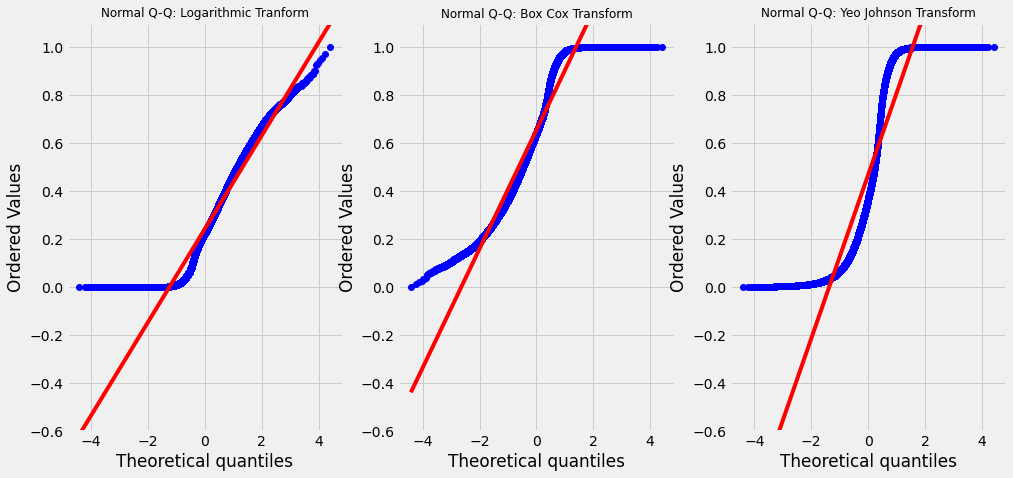

In [46]:
fig, ax = plt.subplots(1,3, figsize=(15, 7))

stats.probplot(y_training['log'], dist=stats.norm, plot=ax[0])
ax[0].set_title('Normal Q-Q: Logarithmic Tranform',fontsize=12)
ax[0].set_ylim([-0.6,1.1])
stats.probplot(y_training['boxcox'], dist=stats.norm, plot=ax[1])
ax[1].set_title('Normal Q-Q: Box Cox Transform',fontsize=12)
ax[1].set_ylim([-0.6,1.1])
stats.probplot(y_training['yeojohnson'], dist=stats.norm, plot=ax[2])
ax[2].set_title('Normal Q-Q: Yeo Johnson Transform',fontsize=12)
ax[2].set_ylim([-0.6,1.1])
plt.show()

### Actionable Insights <a id = 'actionable'></a>

In [47]:
# Test against null hypothesis  that predicted values in Guam and Puerto Rico are different from 
# all states in the United States 
gupr = pd.read_csv('https://raw.githubusercontent.com/jonahwinninghoff/Springboard_Capstone_Project/main/Assets/PCA_with_Guam_and_Puerto_Rico')
gupr = gupr[gupr['Four Quarter Average Score'] !=0]
gupr_pred = pd.DataFrame(rfr_model.predict(gupr.iloc[:,3:])).rename(columns={0:'score'})

In [48]:
other_states = pd.DataFrame(y_train).sample(n=70,replace=True,random_state=42).rename(columns={0:'score'})
other_states['group'] = 'US'

In [49]:
gupr_pred['group'] = 'GU_PR'
df = pd.concat([gupr_pred,other_states],axis=0)

In [50]:
v1 = float(np.var(df[df['group'] != 'GU_PR'],ddof=1))
v2 = float(np.var(df[df['group'] == 'GU_PR'],ddof=1))
n1 = float(len(df[df['group'] != 'GU_PR']))
n2 = float(len(df[df['group'] == 'GU_PR']))
n1 = float(len(df[df['group'] != 'GU_PR']))
n2 = float(len(df[df['group'] == 'GU_PR']))
m1 = float(np.mean(df[df['group'] != 'GU_PR']))
m2 = float(np.mean(df[df['group'] == 'GU_PR']))

In [51]:
truevalue = np.mean(gupr['Four Quarter Average Score']/100)
delta = truevalue - m1

In [59]:
def t_statistics(m1,m2,delta,v1,v2,n1,n2):
    top = abs(abs(m1 - m2) - abs(delta))
    bottom = np.sqrt(((n1-1)*v1+(n2-1)*v2)/(n1+n2-2))*(1/n1+1/n2)
    t = top/bottom
    return t

In [61]:
from scipy.stats import t
t.sf(t_statistics(m1,m2,delta,v1,v2,n1,n2),df=n1+n2-2)

0.03478204805500001

The null hypothesis that both groups are different from each other is rejected.